In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [19]:

# Set the option to display the full content of columns
pd.set_option('display.max_colwidth', None)


In [ ]:
# Ensure NLTK data is downloaded (run these once)
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4') # Open Multilingual Wordnet (required for WordNetLemmatizer)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\parth\AppData\Roaming\nltk_data...


True

### Load The dataset

In [2]:
df = pd.read_csv('It Support Ticket Data.csv',index_col=0)
df.head()


,Body,Department,Priority,Tags
0,"Dear Customer Support Team,I am writing to rep...",Technical Support,high,"['Account', 'Disruption', 'Outage', 'IT', 'Tec..."
1,"Dear Customer Support Team,I hope this message...",Returns and Exchanges,medium,"['Product', 'Feature', 'Tech Support']"
2,"Dear Customer Support Team,I hope this message...",Billing and Payments,low,"['Billing', 'Payment', 'Account', 'Documentati..."
3,"Dear Support Team,I hope this message reaches ...",Sales and Pre-Sales,medium,"['Product', 'Feature', 'Feedback', 'Tech Suppo..."
4,"Dear Customer Support,I hope this message reac...",Technical Support,high,"['Feature', 'Product', 'Documentation', 'Feedb..."


In [3]:
df.dropna(inplace=True)

In [4]:
df.isnull().sum()

Body          0
Department    0
Priority      0
Tags          0
dtype: int64

In [5]:
departments = df['Department'].unique().tolist()

In [6]:
priority = df['Priority'].unique().tolist()[::-1]
priority  

['low', 'medium', 'high']

In [7]:
df.columns.tolist()

['Body', 'Department', 'Priority', 'Tags']

In [9]:
X = df['Body']
y_department = df['Department']
y_priority = df['Priority']

In [12]:
# --- 2. Data Preprocessing ---

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
def preprocess_text(text):
    text = str(text).lower() # Convert to string and lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters
    tokens = text.split() # Simple tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Lemmatize and remove stop words
    return ' '.join(tokens)

In [14]:
print("\nStarting text preprocessing...")
X_preprocessed = X.apply(preprocess_text)
print("Text preprocessing complete.")
print("Sample preprocessed text:")
print(X_preprocessed.head())



Starting text preprocessing...
Text preprocessing complete.
Sample preprocessed text:
0    dear customer support teami writing report sig...
1    dear customer support teami hope message reach...
2    dear customer support teami hope message find ...
3    dear support teami hope message reach well rea...
4    dear customer supporti hope message reach good...
Name: Body, dtype: object


In [23]:
X_preprocessed.head(1)


0    dear customer support teami writing report significant problem centralized account management portal currently appears offline outage blocking access account setting leading substantial inconvenience attempted log multiple time using different browser device issue persistscould please provide update outage status estimated time resolution also alternative way access manage account downtime
Name: Body, dtype: object

In [ ]:
# df['Body'][1]

'Dear Customer Support Team,I hope this message reaches you well. I am reaching out to request detailed information about the capabilities of your smart home integration products listed on your website. As a potential customer aiming to develop a seamlessly interconnected home environment, it is essential to understand how your products interact with various smart home platforms.Could you kindly provide detailed compatibility information with popular smart home ecosystems such as Amazon Alexa, Google Assistant, and Apple?'

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [25]:
# --- 3. Feature Extraction (TF-IDF) ---
print("Starting feature extraction with TF-IDF...")

# Initialize the TF-IDF Vectorizer
# We'll limit the number of features to the top 5000 most frequent words
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X_preprocessed)

print("Feature extraction complete.")
print("Shape of TF-IDF matrix:", X_tfidf.shape)


Starting feature extraction with TF-IDF...
Feature extraction complete.
Shape of TF-IDF matrix: (29650, 5000)


In [28]:
# --- 4. Splitting Data into Training and Testing sets ---

# For Department classification
# We use stratify to ensure the distribution of departments is the same in train and test sets
X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(
    X_tfidf, y_department, test_size=0.2, random_state=42, stratify=y_department
)

# For Priority classification
# We also stratify for the priority target
X_train_prio, X_test_prio, y_train_prio, y_test_prio = train_test_split(
    X_tfidf, y_priority, test_size=0.2, random_state=42, stratify=y_priority
)

print("Data has been split into training and testing sets for both targets.")
print("Department training set size:", X_train_dept.shape[0])
print("Department testing set size:", X_test_dept.shape[0])


Data has been split into training and testing sets for both targets.
Department training set size: 23720
Department testing set size: 5930



--- Department Classification ---
Training the Department classifier...
Training complete.

Accuracy for Department classification: 0.5121

Classification Report for Department:
                                 precision    recall  f1-score   support

           Billing and Payments       0.84      0.74      0.79       604
               Customer Service       0.44      0.42      0.43       896
                General Inquiry       1.00      0.06      0.11        84
                Human Resources       0.95      0.18      0.30       114
                     IT Support       0.48      0.26      0.34       700
                Product Support       0.44      0.46      0.45      1108
          Returns and Exchanges       0.82      0.21      0.33       293
            Sales and Pre-Sales       0.63      0.19      0.29       177
Service Outages and Maintenance       0.84      0.49      0.62       231
              Technical Support       0.48      0.74      0.58      1723

                

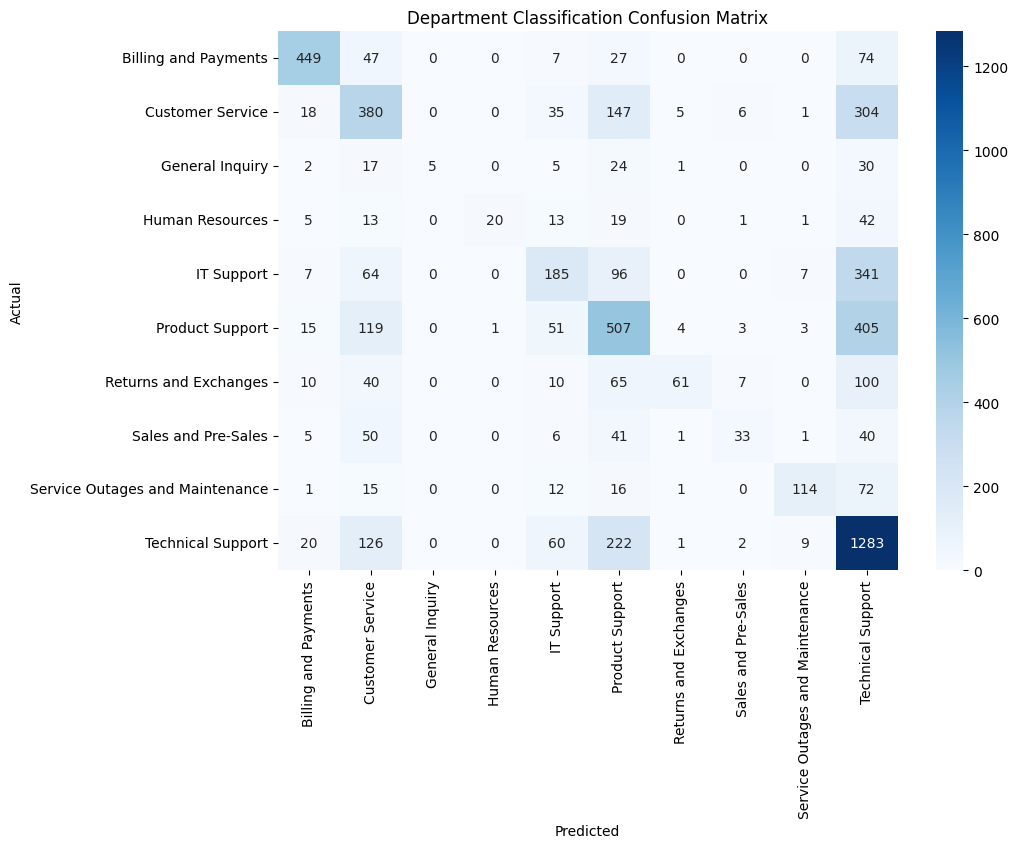

In [34]:
# --- 5. Train and Evaluate Logistic Regression for Department Classification ---
print("\n--- Department Classification ---")

# Initialize and train the model
# We set max_iter to 1000 to ensure the model converges
lr_dept = LogisticRegression(random_state=42, max_iter=1000)
print("Training the Department classifier...")
lr_dept.fit(X_train_dept, y_train_dept)
print("Training complete.")

# Make predictions on the test set
y_pred_dept = lr_dept.predict(X_test_dept)

# Evaluate the model
accuracy_dept = accuracy_score(y_test_dept, y_pred_dept)
print(f"\nAccuracy for Department classification: {accuracy_dept:.4f}")

print("\nClassification Report for Department:")
print(classification_report(y_test_dept, y_pred_dept))

# Display Confusion Matrix for a visual evaluation
print("\nConfusion Matrix for Department:")
cm_dept = confusion_matrix(y_test_dept, y_pred_dept)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dept, annot=True, fmt='d', cmap='Blues', xticklabels=lr_dept.classes_, yticklabels=lr_dept.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Department Classification Confusion Matrix')
plt.show()



--- Priority Classification ---
Training the Priority classifier...
Training complete.

Accuracy for Priority classification: 0.5784

Classification Report for Priority:
              precision    recall  f1-score   support

         low       0.58      0.30      0.39      1203
      medium       0.56      0.66      0.60      2425
        high       0.60      0.64      0.62      2302

    accuracy                           0.58      5930
   macro avg       0.58      0.53      0.54      5930
weighted avg       0.58      0.58      0.57      5930


Confusion Matrix for Priority:


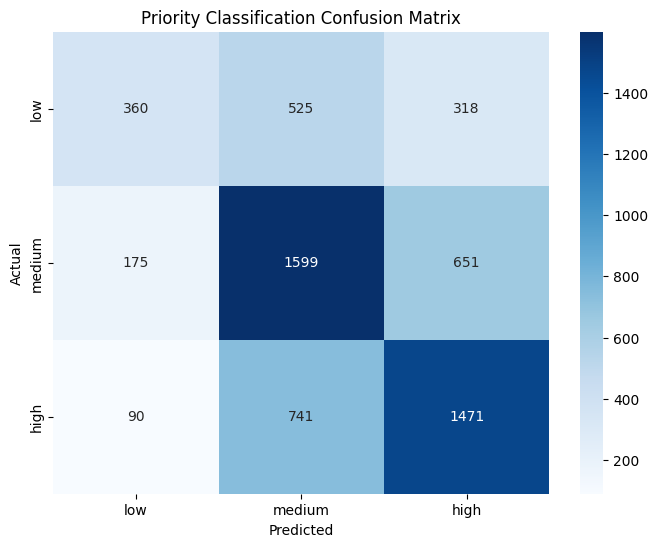

In [33]:
# --- 6. Train and Evaluate Logistic Regression for Priority Classification ---
print("\n--- Priority Classification ---")

# Initialize and train the model
lr_prio = LogisticRegression(random_state=42, max_iter=1000)
print("Training the Priority classifier...")
lr_prio.fit(X_train_prio, y_train_prio)
print("Training complete.")

# Make predictions on the test set
y_pred_prio = lr_prio.predict(X_test_prio)

# Evaluate the model
accuracy_prio = accuracy_score(y_test_prio, y_pred_prio)
print(f"\nAccuracy for Priority classification: {accuracy_prio:.4f}")

# Use the 'priority' list you created earlier for consistent label ordering
print("\nClassification Report for Priority:")
print(classification_report(y_test_prio, y_pred_prio, labels=priority))

# Display Confusion Matrix
print("\nConfusion Matrix for Priority:")
cm_prio = confusion_matrix(y_test_prio, y_pred_prio, labels=priority)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_prio, annot=True, fmt='d', cmap='Blues', xticklabels=priority, yticklabels=priority)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Priority Classification Confusion Matrix')
plt.show()


### logistic Regression output
1. for Department :- 0.5121 => 51.21%
2. for Priority :- 0.5784 => 57.84